In [ ]:
## Imports

# Notes

- not sure if the synthetitc dataset is useful for visualizing pca for feature selection, maybe we should reduce the features to 20 (10 signal 10 noise)
- TODO: Continue PCA feature extraction
- TODO: Does it make sense to do PCA after the first part? We can also do it at the end, or we leave it and add more in-depth analysis of Principle components (let's see what they are made out of -> but then probably a dataset with more interpretability would work better)
- Add something to Lasso and Ridge Cross Validation functions from SKLearn -> better explanations
- I think we probably can add Stepwise regression and hierarhcical clustering of feature correlations no? This notebook is not too loaded


# Table of Contents

<br><br>
# **Hands-On: Feature Selection and Regularization**

In this notebook, we'll explore a critical challenge in machine learning: **what happens when we have more features than samples?** We'll use a completely synthetic dataset where **no true relationships exist** to demonstrate how easy it is to find "significant" patterns purely by chance.

**Key Learning Objectives:**
- Understand the multiple testing problem in high-dimensional settings
- See how random correlations can appear statistically significant
- Learn why regularization is essential for high-dimensional data
- Explore proper validation techniques to avoid false discoveries

# Finding "Significant" Patterns in Noise

First we look at a completely random dataset with 50 samples, 1000 features and 1 target variable. So there are no "real" relationships present in the data, however the tools we explored up to now may detect relationships.

We'll perform the following experiment: **test every single feature** for correlation with our target variable. Remember, our data is completely random - there should be NO real relationships.

**What we're testing:**
- Calculate correlation coefficient between each of the 1000 features and the target
- Compute p-values to test if correlations are "statistically significant" (p < 0.05)
- See how many features appear "significant" purely by chance

**The Multiple Testing Problem:**
When we test many hypotheses simultaneously, we expect some to appear significant by pure chance:
- With α = 0.05, we expect 5% of tests to be "significant" even for random data
- 1000 features × 0.05 = **~50 expected "significant" correlations**
- This is the **false discovery** problem in high-dimensional data!

Let's see if this theoretical expectation matches reality...

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Load our synthetic dataset
df = pd.read_csv('synthetic_highdim_random_dataset.csv')
X = df.drop('target', axis=1)
y = df['target']

print(f"Dataset shape: {df.shape}")
print(f"Samples: {X.shape[0]}, Features: {X.shape[1]}")
print(f"Ratio: {X.shape[1]/X.shape[0]:.1f} features per sample!")
print(f"\n⚠️  Remember: ALL data is completely random - no true relationships exist!")

Dataset shape: (50, 1001)
Samples: 50, Features: 1000
Ratio: 20.0 features per sample!

⚠️  Remember: ALL data is completely random - no true relationships exist!


🎲 RANDOM DATA ANALYSIS:
Features with p < 0.05: 45 out of 1000
Expected by chance: ~50
Strongest 'significant' correlation: 0.4680


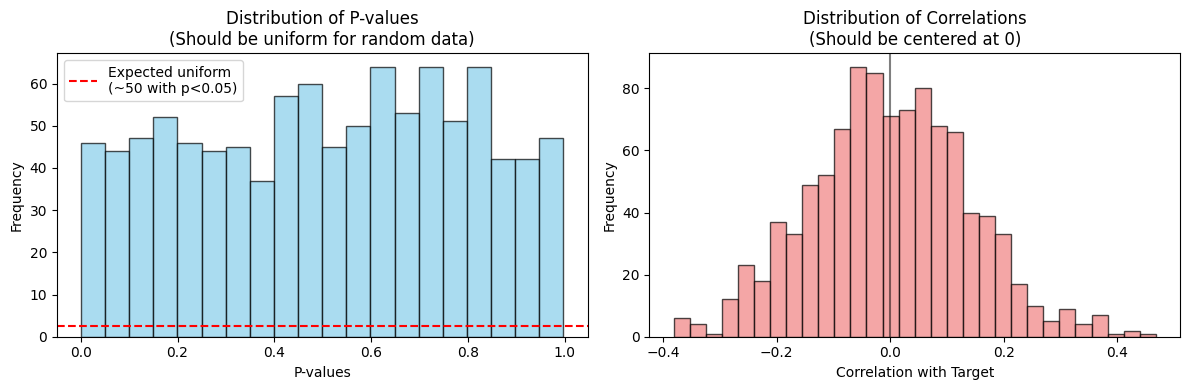

In [4]:
# Calculate correlations between ALL features and target
correlations = []
p_values = []

for feature in X.columns:
    corr, p_val = stats.pearsonr(X[feature], y)
    correlations.append(corr)
    p_values.append(p_val)

corr_df = pd.DataFrame({
    'feature': X.columns,
    'correlation': correlations,
    'p_value': p_values,
    'abs_correlation': np.abs(correlations)
}).sort_values('abs_correlation', ascending=False)

# Find "significant" correlations
significant = corr_df[corr_df['p_value'] < 0.05]

print(f"🎲 RANDOM DATA ANALYSIS:")
print(f"Features with p < 0.05: {len(significant)} out of {len(corr_df)}")
print(f"Expected by chance: ~{len(corr_df) * 0.05:.0f}")
print(f"Strongest 'significant' correlation: {significant.iloc[0]['correlation']:.4f}")

# Visualize the distribution of p-values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(p_values, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axhline(y=len(p_values)*0.05/20, color='red', linestyle='--', 
            label=f'Expected uniform\n(~{len(p_values)*0.05:.0f} with p<0.05)')
plt.xlabel('P-values')
plt.ylabel('Frequency')
plt.title('Distribution of P-values\n(Should be uniform for random data)')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(correlations, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
plt.xlabel('Correlation with Target')
plt.ylabel('Frequency')
plt.title('Distribution of Correlations\n(Should be centered at 0)')

plt.tight_layout()
plt.show()

### Results:
- **45 features with p < 0.05** out of 1000 total features
- **Strongest "significant" correlation: 0.47** - quite convincing looking!

### Left Plot - P-value Distribution:
- **Uniform distribution**: P-values are spread evenly from 0 to 1 (as expected for random data)
- **Red dashed line**: Shows expected frequency for each bin under uniform distribution
- **The trap**: Even random data produces some low p-values that appear "significant"!

### Right Plot - Correlation Distribution:
- **Normal distribution centered at 0**: Exactly what we expect for random correlations
- **No real relationships**: The bell curve confirms no systematic patterns exist
- **Random scatter**: Some correlations appear strong (like our 0.47!) but are pure noise

### Key Insights:
1. **Theory matches reality**: We got 45 vs expected ~50 - statistical theory works!
2. **0.47 correlation looks impressive** but it's completely meaningless random noise
3. **Without multiple testing correction**, we'd wrongly conclude these 45 features are important
4. **This is why high-dimensional data is dangerous** - noise can easily masquerade as signal

**The Bottom Line:** In high dimensions with small samples, **random chance can create convincing but false patterns**. Let's see what we can do against this now!

# Overfitting to Noise

Now we will demonstrate how Linear Models can overfit to noise if we have a lot of features and not enough samples for the model to learn the actual relevant relationships. For this we use a new generated dataset that has 10 relevant features that have a relationship with the target value and 990 features that are just random noise. 

**The Experiment:**
1. Start with only the **10 true signal features** (best case scenario)
2. Progressively add noise features: 10 → 50 → 100 → 200 → 500 → 1000 total features
3. Train linear regression on each feature set using 90% of data
4. Test on remaining 10% to measure generalization
5. Track how training vs test performance changes as we add noise

**Expected Results:**
- **Training error should decrease** (or stay low) as we add features - more parameters = better fit to training data
- **Test error should increase** as noise features confuse the model and cause overfitting
- **The gap between train/test** will grow dramatically as we move from 10 → 1000 features

This demonstrates why **"more features = better"** is a dangerous assumption in machine learning!

Training samples: 45
Test samples: 5

Testing with 10 features...
  Train MSE: 0.0077, Test MSE: 0.0126
  Train R²: 1.0000, Test R²: 1.0000

Testing with 50 features...
  Train MSE: 0.0000, Test MSE: 2978.4471
  Train R²: 1.0000, Test R²: 0.8032

Testing with 100 features...
  Train MSE: 0.0000, Test MSE: 3656.2755
  Train R²: 1.0000, Test R²: 0.7585

Testing with 200 features...
  Train MSE: 0.0000, Test MSE: 16111.7193
  Train R²: 1.0000, Test R²: -0.0644

Testing with 500 features...
  Train MSE: 0.0000, Test MSE: 16835.3089
  Train R²: 1.0000, Test R²: -0.1122

Testing with 1000 features...
  Train MSE: 0.0000, Test MSE: 20584.0532
  Train R²: 1.0000, Test R²: -0.3598


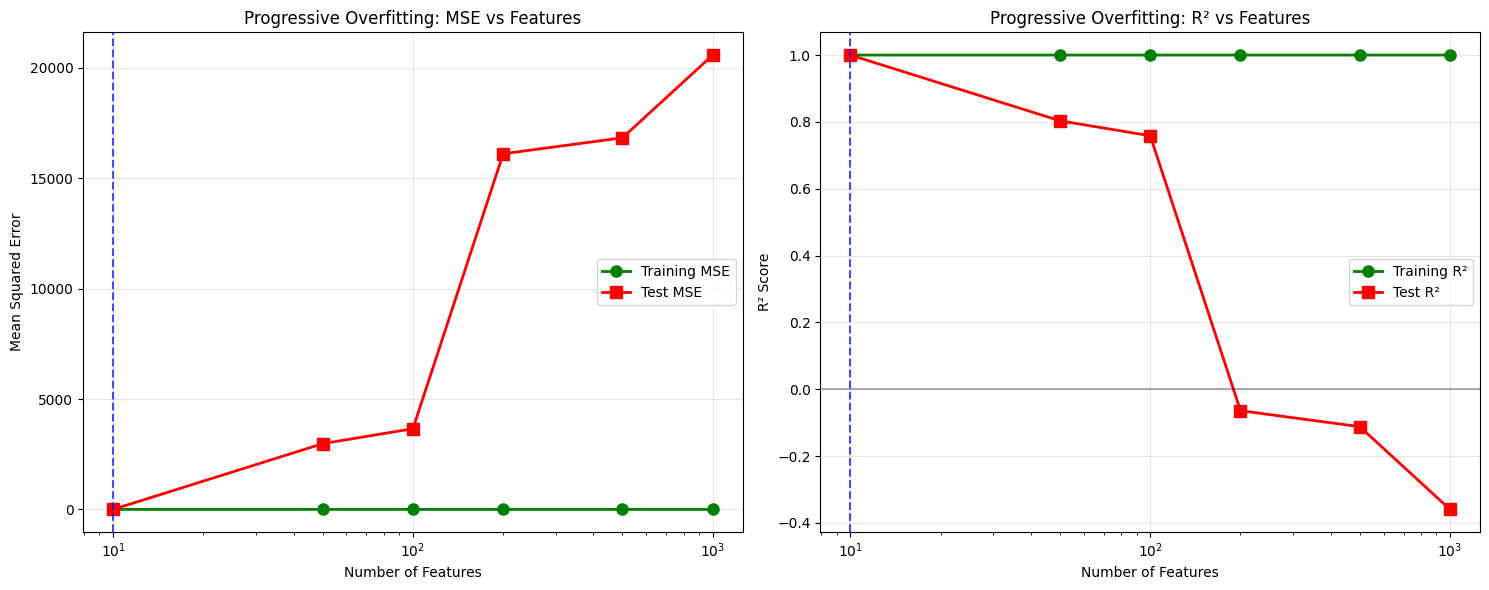

In [10]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import json

# Load the mixed signal-noise dataset
df = pd.read_csv('synthetic_highdim_signal_dataset.csv')

X = df.drop('target', axis=1)
y = df['target']

# Split into train/test (90%/10%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# Define progressive feature sets to test
feature_counts = [10, 50, 100, 200, 500, 1000]
train_errors = []
test_errors = []
train_r2_scores = []
test_r2_scores = []

for n_features in feature_counts:
    print(f"\nTesting with {n_features} features...")
    
    # Select features: first 10 are signal, rest are noise
    selected_features = X.columns[:n_features]
    X_train_subset = X_train[selected_features]
    X_test_subset = X_test[selected_features]
    
    # Fit linear regression
    lr = LinearRegression()
    lr.fit(X_train_subset, y_train)
    
    # Predictions
    train_pred = lr.predict(X_train_subset)
    test_pred = lr.predict(X_test_subset)
    
    # Calculate errors
    train_mse = mean_squared_error(y_train, train_pred)
    test_mse = mean_squared_error(y_test, test_pred)
    train_r2 = lr.score(X_train_subset, y_train)
    test_r2 = lr.score(X_test_subset, y_test)
    
    train_errors.append(train_mse)
    test_errors.append(test_mse)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)
    
    print(f"  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
    print(f"  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: MSE vs number of features
ax1.plot(feature_counts, train_errors, 'o-', linewidth=2, markersize=8, 
         color='green', label='Training MSE')
ax1.plot(feature_counts, test_errors, 's-', linewidth=2, markersize=8, 
         color='red', label='Test MSE')
ax1.set_xlabel('Number of Features')
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('Progressive Overfitting: MSE vs Features')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')
ax1.axvline(x=10, color='blue', linestyle='--', alpha=0.7, label='True signal features')

# Plot 2: R² vs number of features
ax2.plot(feature_counts, train_r2_scores, 'o-', linewidth=2, markersize=8, 
         color='green', label='Training R²')
ax2.plot(feature_counts, test_r2_scores, 's-', linewidth=2, markersize=8, 
         color='red', label='Test R²')
ax2.set_xlabel('Number of Features')
ax2.set_ylabel('R² Score')
ax2.set_title('Progressive Overfitting: R² vs Features')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log')
ax2.axvline(x=10, color='blue', linestyle='--', alpha=0.7, label='True signal features')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

The plots perfectly demonstrate the expected overfitting behavior as we add noise features to our signal:

### What We Observe:

**Left Plot (MSE) - The Overfitting Story:**
- **Training MSE (green)** stays consistently low across all feature counts - the model can always fit the training data well
- **Test MSE (red)** dramatically increases as we add noise features, showing catastrophic generalization failure

**Right Plot (R²) - The Same Story, Different Metric:**
- **Training R² (green)** remains high (~1.0) - perfect fit to training data regardless of noise
- **Test R² (red)** plummets from ~1.0 to negative values as noise features overwhelm the signal
- **Negative R²** means the model performs worse than simply predicting the mean!

### Key Insights:

1. **Perfect Signal (10 features)**: Both train and test performance are excellent - the model captures the true relationship
2. **Adding Noise Hurts**: Each additional noise feature gives the model more ways to memorize training data instead of learning the true pattern
3. **Training Performance Misleads**: The model appears to improve on training data but is actually getting worse at the real task
4. **The Curse of Dimensionality**: More features ≠ better performance when many features are irrelevant

### The Critical Lesson:
In reality, we often have many features in our datasets, but **we don't know which ones are actually relevant**. As we can see, adding noisy features to our dataset decreases the performance of our models, which is something we try to avoid. This is why we will look at **methods to effectively select features and regularization techniques** in high-dimensional settings next!

# Principal Component Analysis (PCA): Finding Structure in High Dimensions

We have already seen ways to reduce the dimensionality of datasets. Until now we used these techniques to mainly visualize our datasets, however we can also use them to filter out unnecessary information. **Principal component analysis** is commonly used exactly for this purpose, because it let's us create new features that keep the most variance present in the data:

**The PCA Approach:**
Instead of selecting individual features, PCA creates **new features** (principal components) that are linear combinations of all original features. The goal is to:

- **Reduce dimensionality** by projecting data onto fewer dimensions
- **Remove redundancy** by creating uncorrelated components  
- **Preserve variance** by keeping k components that explain the most and desired amount of variation in the data
- **Combat overfitting** by working in a lower-dimensional space

Let's see if PCA can help us separate signal from noise in our mixed dataset!

🔧 DATA PREPARATION:
Original shape: (200, 22)
Features standardized: mean ≈ 0, std ≈ 1

📊 VARIANCE ANALYSIS:
  80.0% variance: 6 components (27.3% of original)
  90.0% variance: 8 components (36.4% of original)
  95.0% variance: 9 components (40.9% of original)
  99.0% variance: 16 components (72.7% of original)


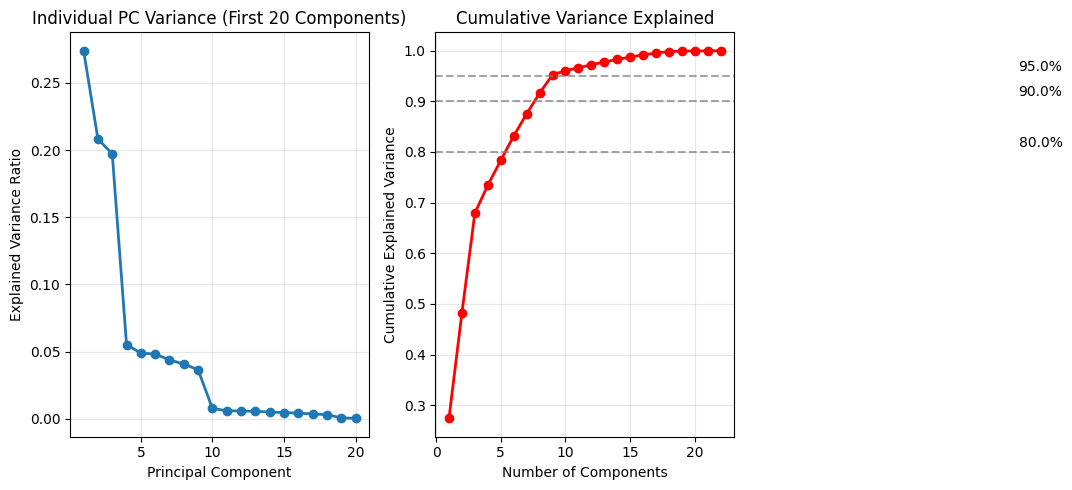

In [30]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

df = pd.read_csv('structured_dataset_for_pca.csv')

# Load data and separate features/target
X = df.drop('target', axis=1)#.iloc[:, :20]
y = df['target']

# Step 1: Standardize the features (essential for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("🔧 DATA PREPARATION:")
print(f"Original shape: {X.shape}")
print(f"Features standardized: mean ≈ 0, std ≈ 1")

# Step 2: Fit PCA on all components first to analyze variance
pca_full = PCA()
pca_full.fit(X_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Find number of components for different variance thresholds
thresholds = [0.8, 0.9, 0.95, 0.99]
components_needed = {}
for threshold in thresholds:
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    components_needed[threshold] = n_components

print(f"\n📊 VARIANCE ANALYSIS:")
for threshold, n_comp in components_needed.items():
    print(f"  {threshold*100}% variance: {n_comp} components ({n_comp/X.shape[1]*100:.1f}% of original)")

# Visualize explained variance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 21), pca_full.explained_variance_ratio_[:20], 'o-', linewidth=2)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Individual PC Variance (First 20 Components)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, 23), cumulative_variance[:50], 'o-', linewidth=2, color='red')
for threshold in [0.8, 0.9, 0.95]:
    plt.axhline(y=threshold, color='gray', linestyle='--', alpha=0.7)
    plt.text(45, threshold+0.01, f'{threshold*100}%', fontsize=10)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Variance Explained')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

🧪 TESTING PCA + LINEAR REGRESSION:
BASELINE (1000 features): Train R² = 0.8868, Test R² = 0.8548
PCA (  1 components): Train R² = 0.4562, Test R² = 0.3132, Variance = 0.280
PCA (  2 components): Train R² = 0.5727, Test R² = 0.4111, Variance = 0.485
PCA (  3 components): Train R² = 0.8741, Test R² = 0.8741, Variance = 0.682
PCA (  5 components): Train R² = 0.8758, Test R² = 0.8734, Variance = 0.789
PCA (  7 components): Train R² = 0.8779, Test R² = 0.8750, Variance = 0.880


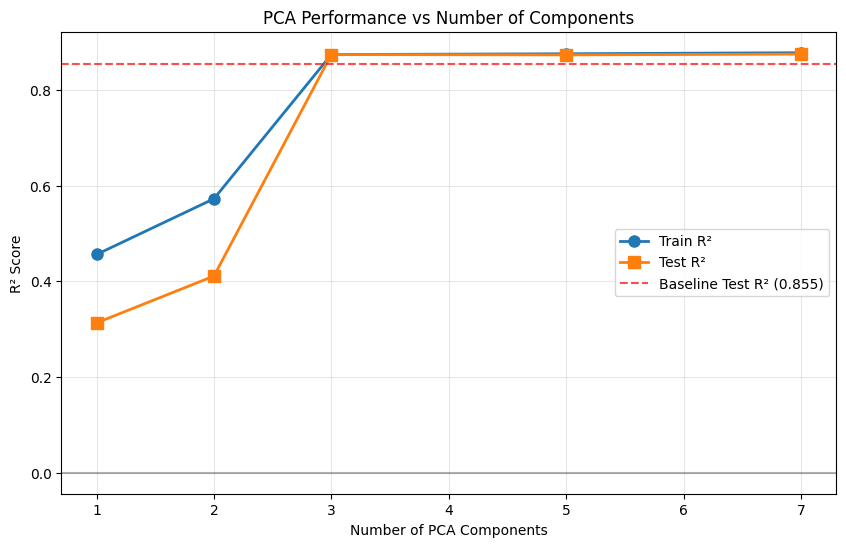

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Split data for consistent comparison
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Test different numbers of PCA components
n_components_to_test = [1, 2, 3, 5, 7]
results = []

print("🧪 TESTING PCA + LINEAR REGRESSION:")
print("=" * 60)

# Baseline: Original high-dimensional data
lr_original = LinearRegression()
lr_original.fit(X_train, y_train)
train_r2_orig = lr_original.score(X_train, y_train)
test_r2_orig = lr_original.score(X_test, y_test)
print(f"BASELINE (1000 features): Train R² = {train_r2_orig:.4f}, Test R² = {test_r2_orig:.4f}")

# Test PCA with different component counts
for n_comp in n_components_to_test:
    # Apply PCA
    pca = PCA(n_components=n_comp)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Fit linear regression on PCA components
    lr_pca = LinearRegression()
    lr_pca.fit(X_train_pca, y_train)
    
    # Evaluate
    train_r2 = lr_pca.score(X_train_pca, y_train)
    test_r2 = lr_pca.score(X_test_pca, y_test)
    variance_explained = np.sum(pca.explained_variance_ratio_)
    
    results.append({
        'n_components': n_comp,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'variance_explained': variance_explained
    })
    
    print(f"PCA ({n_comp:3d} components): Train R² = {train_r2:.4f}, Test R² = {test_r2:.4f}, "
          f"Variance = {variance_explained:.3f}")

# Visualize results
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(results_df['n_components'], results_df['train_r2'], 'o-', label='Train R²', linewidth=2, markersize=8)
plt.plot(results_df['n_components'], results_df['test_r2'], 's-', label='Test R²', linewidth=2, markersize=8)
plt.axhline(y=test_r2_orig, color='red', linestyle='--', alpha=0.7, label=f'Baseline Test R² ({test_r2_orig:.3f})')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Number of PCA Components')
plt.ylabel('R² Score')
plt.title('PCA Performance vs Number of Components')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Overview, key insights etc

# Regularization Methods

Another approach to improve the fit of the model to a high-dimensional dataset are **Regularization Methods**. Here we don't perform dimensionality reduction or any other tool to filter out features or information, but we *constrain* or *regularize* the **coefficients** of our features towards zero! We will take a look at the two best-known techniques **ridge** and **lasso regression**, as well as their combination **elastic net**.

## Ridge Regression: Penalizing Large Coefficients (Again we should use a different dataset, but let that be a problem for once i got all the code and ideas)

**The Core Idea:**
Ridge regression adds a **penalty term** to the standard linear regression loss function that discourages large coefficient values:

**Standard Linear Regression:**
Loss = MSE = Σ(y - ŷ)²

**Ridge Regression:**
Loss = MSE + α × Σ(β²)

**How Ridge Works:**
- **α (alpha)**: Regularization strength parameter
  - α = 0: No penalty for size of parameters β (standard linear regression)
  - α → ∞: All coefficients β shrink toward zero
- **L2 Penalty**: Penalizes the **sum of squared coefficients**
- **Effect**: Coefficients are **shrunk** but never exactly zero
- **Benefit**: Reduces overfitting by preventing any single feature from dominating

**When Ridge Helps:**
- Many features are somewhat relevant (multicollinearity)
- Want to keep all features but reduce their impact
- Prefer smooth, continuous shrinkage over feature elimination

In [38]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Load our mixed signal-noise dataset
df = pd.read_csv('synthetic_highdim_signal_dataset.csv')
X = df.drop('target', axis=1)
y = df['target']

# Split and standardize (crucial for regularization!)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("🎯 RIDGE REGRESSION ANALYSIS")
print("=" * 50)
print(f"Dataset: {X.shape[0]} samples, {X.shape[1]} features")
print(f"True signal features: 10 (signal_00 to signal_09)")
print(f"Noise features: 990 (noise_000 to noise_989)")

# Test different alpha values
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_mse = []
test_mse = []
n_features_used = []

for alpha in alphas:
    # Fit Ridge regression
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    
    # Evaluate performance with MSE
    train_pred = ridge.predict(X_train_scaled)
    test_pred = ridge.predict(X_test_scaled)
    
    train_error = mean_squared_error(y_train, train_pred)
    test_error = mean_squared_error(y_test, test_pred)
    
    train_mse.append(train_error)
    test_mse.append(test_error)
    
    # Count "effectively used" features (coefficient magnitude > 0.01)
    n_effective = np.sum(np.abs(ridge.coef_) > 0.01)
    n_features_used.append(n_effective)
    
    print(f"α = {alpha:6.3f}: Train MSE = {train_error:.4f}, Test MSE = {test_error:.4f}, "
          f"Features |coef| > 0.01: {n_effective}")

# Find optimal alpha using cross-validation
ridge_cv = RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5)
ridge_cv.fit(X_train_scaled, y_train)
optimal_alpha = ridge_cv.alpha_

# Calculate test MSE for optimal alpha
optimal_test_pred = ridge_cv.predict(X_test_scaled)
optimal_test_mse = mean_squared_error(y_test, optimal_test_pred)

print(f"\n🎯 Optimal α (via CV): {optimal_alpha:.3f}")
print(f"Test MSE with optimal α: {optimal_test_mse:.4f}")

🎯 RIDGE REGRESSION ANALYSIS
Dataset: 50 samples, 1000 features
True signal features: 10 (signal_00 to signal_09)
Noise features: 990 (noise_000 to noise_989)
α =  0.001: Train MSE = 0.0000, Test MSE = 28505.2296, Features |coef| > 0.01: 994
α =  0.010: Train MSE = 0.0000, Test MSE = 28505.2143, Features |coef| > 0.01: 994
α =  0.100: Train MSE = 0.0002, Test MSE = 28505.0610, Features |coef| > 0.01: 994
α =  1.000: Train MSE = 0.0189, Test MSE = 28503.5301, Features |coef| > 0.01: 994
α = 10.000: Train MSE = 1.8547, Test MSE = 28488.3957, Features |coef| > 0.01: 995
α = 100.000: Train MSE = 157.0500, Test MSE = 28352.7669, Features |coef| > 0.01: 992
α = 1000.000: Train MSE = 4949.0798, Test MSE = 27732.9268, Features |coef| > 0.01: 980

🎯 Optimal α (via CV): 0.001
Test MSE with optimal α: 28505.2296


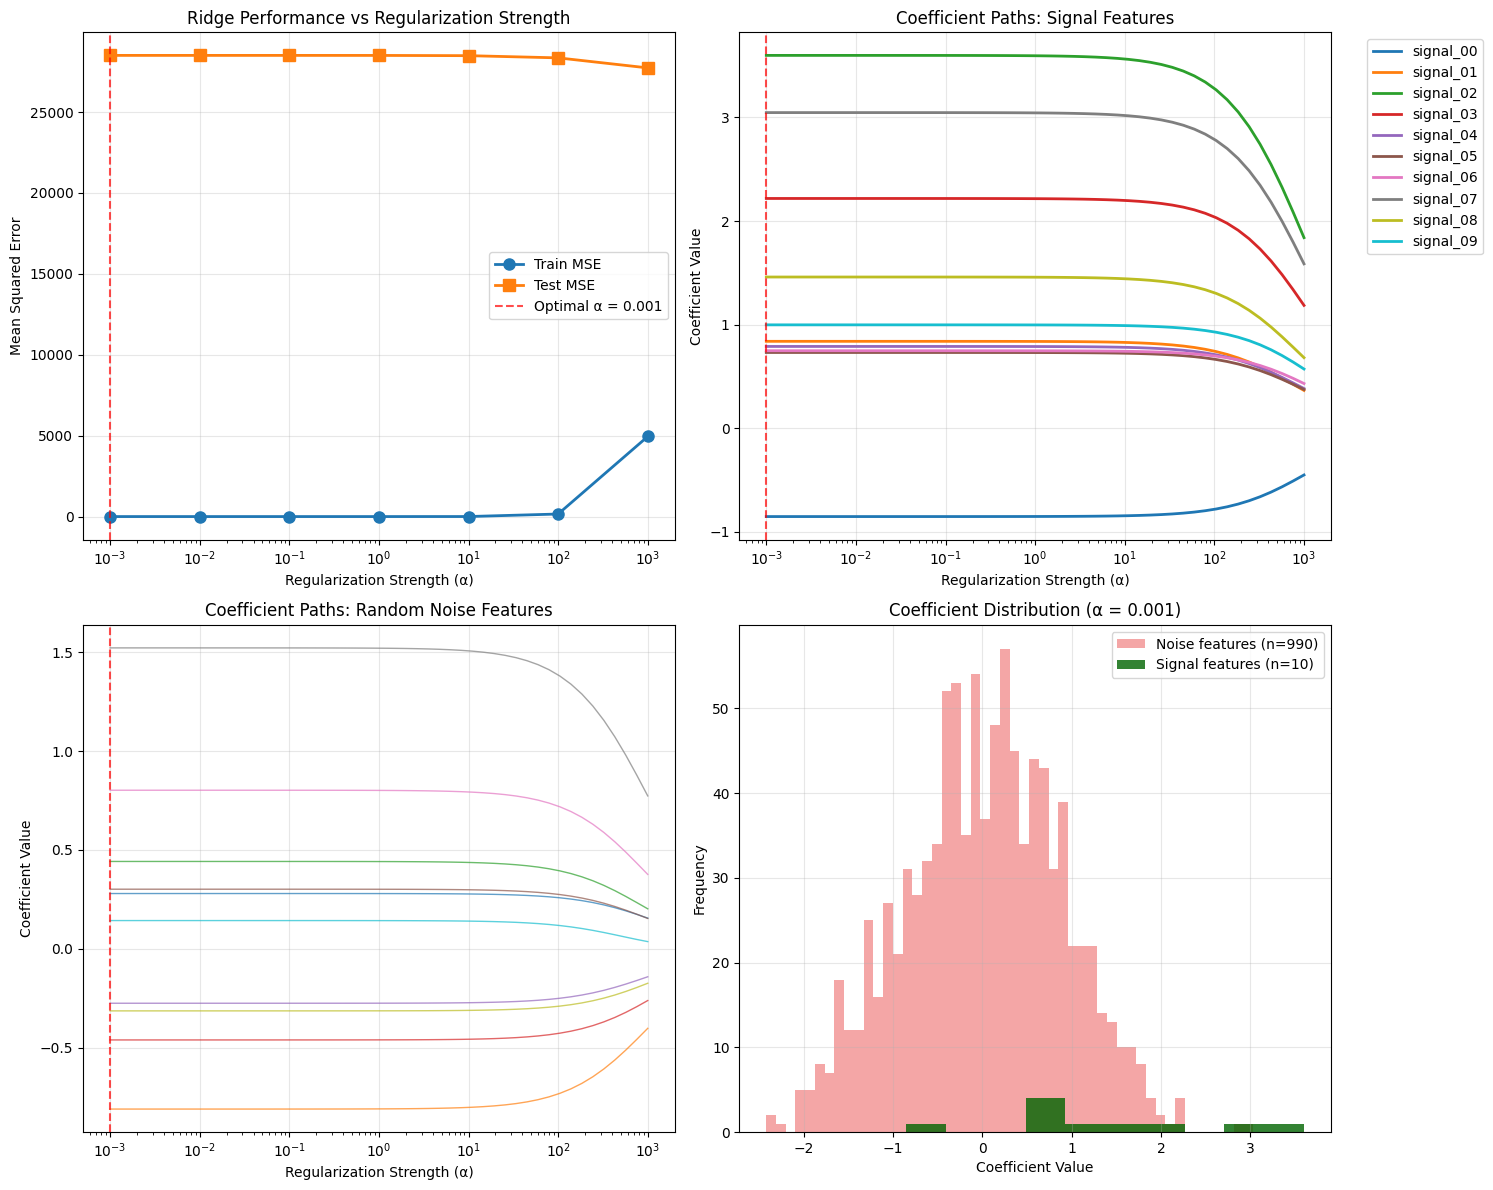

In [39]:
# Visualize Ridge performance across alpha values
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Performance vs Alpha (now using MSE)
ax1.semilogx(alphas, train_mse, 'o-', label='Train MSE', linewidth=2, markersize=8)
ax1.semilogx(alphas, test_mse, 's-', label='Test MSE', linewidth=2, markersize=8)
ax1.axvline(x=optimal_alpha, color='red', linestyle='--', alpha=0.7, label=f'Optimal α = {optimal_alpha:.3f}')
ax1.set_xlabel('Regularization Strength (α)')
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('Ridge Performance vs Regularization Strength')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Coefficient paths for signal features
ridge_coefs = []
alpha_range = np.logspace(-3, 3, 50)
for alpha in alpha_range:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    ridge_coefs.append(ridge.coef_)

ridge_coefs = np.array(ridge_coefs)

# Plot coefficient paths for first 10 features (true signals)
for i in range(10):
    ax2.semilogx(alpha_range, ridge_coefs[:, i], linewidth=2, label=f'signal_{i:02d}')
ax2.axvline(x=optimal_alpha, color='red', linestyle='--', alpha=0.7)
ax2.set_xlabel('Regularization Strength (α)')
ax2.set_ylabel('Coefficient Value')
ax2.set_title('Coefficient Paths: Signal Features')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

# Plot 3: Sample of noise feature coefficients
noise_indices = np.random.choice(range(10, 1000), 10, replace=False)
for i in noise_indices:
    ax3.semilogx(alpha_range, ridge_coefs[:, i], linewidth=1, alpha=0.7)
ax3.axvline(x=optimal_alpha, color='red', linestyle='--', alpha=0.7)
ax3.set_xlabel('Regularization Strength (α)')
ax3.set_ylabel('Coefficient Value')
ax3.set_title('Coefficient Paths: Random Noise Features')
ax3.grid(True, alpha=0.3)

# Plot 4: Distribution of coefficients at optimal alpha
ridge_optimal = Ridge(alpha=optimal_alpha)
ridge_optimal.fit(X_train_scaled, y_train)
signal_coefs = ridge_optimal.coef_[:10]
noise_coefs = ridge_optimal.coef_[10:]

ax4.hist(noise_coefs, bins=50, alpha=0.7, label=f'Noise features (n={len(noise_coefs)})', color='lightcoral')
ax4.hist(signal_coefs, bins=10, alpha=0.8, label=f'Signal features (n={len(signal_coefs)})', color='darkgreen')
ax4.set_xlabel('Coefficient Value')
ax4.set_ylabel('Frequency')
ax4.set_title(f'Coefficient Distribution (α = {optimal_alpha:.3f})')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Short text + transition

## LASSO Regression: Zeroing Out Irrelevant Features

**The Core Idea:**
LASSO (Least Absolute Shrinkage and Selection Operator) adds a different penalty term that can actually **eliminate features** by setting coefficients to exactly zero:

**LASSO Regression:**
Loss = MSE + α × Σ|β|

**Key Differences from Ridge:**
- **L1 Penalty**: Penalizes the **sum of absolute coefficients β** (not squared)
- **Sparse Solutions**: Prefers to set coefficients to **exactly zero**
- **Automatic Feature Selection**: Eliminates irrelevant features completely
- **Sharp Corners**: L1 penalty creates "corners" at zero that trap coefficients

**When LASSO Shines:**
- Only a few features are truly relevant (sparse signals)
- Want automatic feature selection and interpretability
- Prefer simple models with fewer active features
- Need to identify the most important predictors

In [40]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Use the same train/test split as Ridge for fair comparison
print("🎯 LASSO REGRESSION ANALYSIS")
print("=" * 50)
print(f"Dataset: {X.shape[0]} samples, {X.shape[1]} features")
print(f"True signal features: 10 (signal_00 to signal_09)")
print(f"Noise features: 990 (noise_000 to noise_989)")

# Test different alpha values
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_mse = []
test_mse = []
n_features_selected = []

for alpha in alphas:
    # Fit LASSO regression
    lasso = Lasso(alpha=alpha, max_iter=2000)
    lasso.fit(X_train_scaled, y_train)
    
    # Evaluate performance with MSE
    train_pred = lasso.predict(X_train_scaled)
    test_pred = lasso.predict(X_test_scaled)
    
    train_error = mean_squared_error(y_train, train_pred)
    test_error = mean_squared_error(y_test, test_pred)
    
    train_mse.append(train_error)
    test_mse.append(test_error)
    
    # Count features with non-zero coefficients
    n_selected = np.sum(lasso.coef_ != 0)
    n_features_selected.append(n_selected)
    
    print(f"α = {alpha:6.3f}: Train MSE = {train_error:.4f}, Test MSE = {test_error:.4f}, "
          f"Features selected: {n_selected}")

# Find optimal alpha using cross-validation
lasso_cv = LassoCV(alphas=np.logspace(-3, 3, 50), cv=5, max_iter=2000)
lasso_cv.fit(X_train_scaled, y_train)
optimal_alpha = lasso_cv.alpha_

# Calculate test MSE for optimal alpha
optimal_test_pred = lasso_cv.predict(X_test_scaled)
optimal_test_mse = mean_squared_error(y_test, optimal_test_pred)

print(f"\n🎯 Optimal α (via CV): {optimal_alpha:.3f}")
print(f"Test MSE with optimal α: {optimal_test_mse:.4f}")
print(f"Features selected with optimal α: {np.sum(lasso_cv.coef_ != 0)}")

🎯 LASSO REGRESSION ANALYSIS
Dataset: 50 samples, 1000 features
True signal features: 10 (signal_00 to signal_09)
Noise features: 990 (noise_000 to noise_989)
α =  0.001: Train MSE = 0.0000, Test MSE = 1995.6739, Features selected: 642
α =  0.010: Train MSE = 0.0009, Test MSE = 964.9047, Features selected: 80
α =  0.100: Train MSE = 0.0871, Test MSE = 1951.2941, Features selected: 50
α =  1.000: Train MSE = 8.1682, Test MSE = 2114.2809, Features selected: 33
α = 10.000: Train MSE = 650.7709, Test MSE = 3228.6200, Features selected: 17
α = 100.000: Train MSE = 21650.4004, Test MSE = 27185.7159, Features selected: 0
α = 1000.000: Train MSE = 21650.4004, Test MSE = 27185.7159, Features selected: 0

🎯 Optimal α (via CV): 8.286
Test MSE with optimal α: 2866.7011
Features selected with optimal α: 19


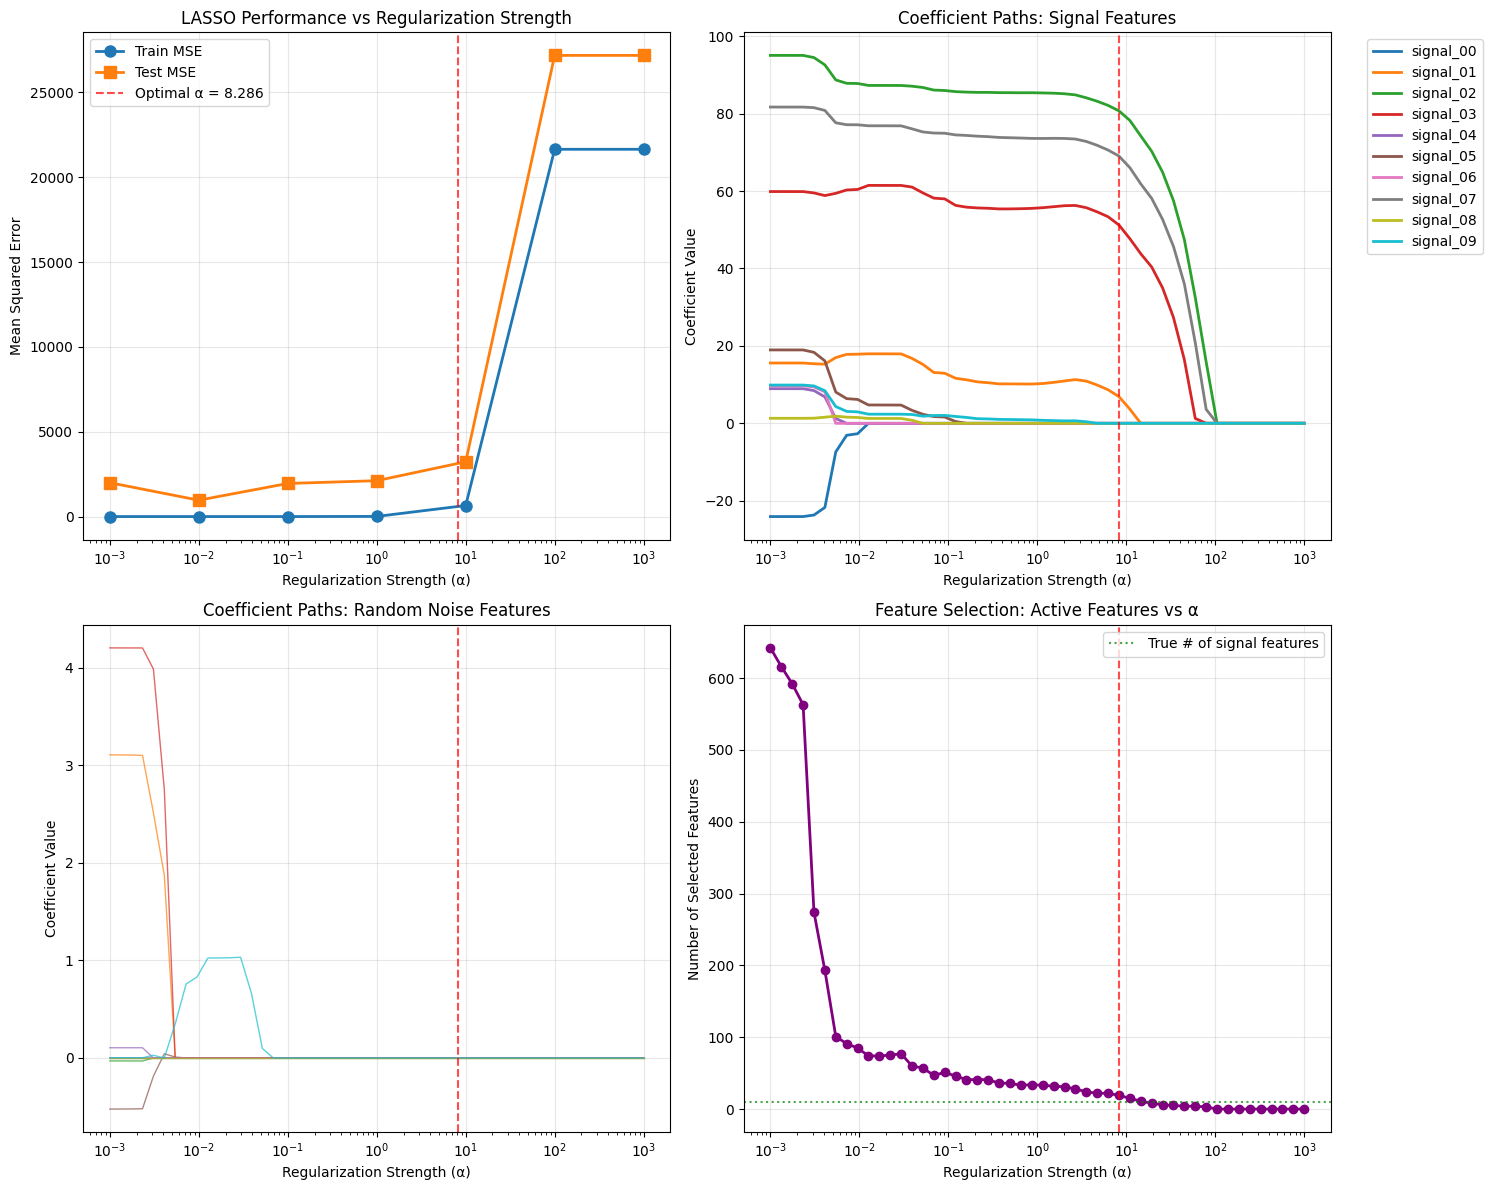


🔍 FEATURE SELECTION ANALYSIS (α = 8.286):
Total features selected: 19
Signal features selected: 4 / 10
Noise features selected: 15 / 990
Signal features found: ['signal_01', 'signal_02', 'signal_03', 'signal_07']
First 10 noise features selected: ['noise_090', 'noise_128', 'noise_192', 'noise_273', 'noise_381', 'noise_412', 'noise_448', 'noise_450', 'noise_570', 'noise_578']...


In [41]:
# Visualize LASSO performance across alpha values
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Performance vs Alpha (MSE)
ax1.semilogx(alphas, train_mse, 'o-', label='Train MSE', linewidth=2, markersize=8)
ax1.semilogx(alphas, test_mse, 's-', label='Test MSE', linewidth=2, markersize=8)
ax1.axvline(x=optimal_alpha, color='red', linestyle='--', alpha=0.7, label=f'Optimal α = {optimal_alpha:.3f}')
ax1.set_xlabel('Regularization Strength (α)')
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('LASSO Performance vs Regularization Strength')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Coefficient paths for signal features
lasso_coefs = []
alpha_range = np.logspace(-3, 3, 50)
for alpha in alpha_range:
    lasso = Lasso(alpha=alpha, max_iter=2000)
    lasso.fit(X_train_scaled, y_train)
    lasso_coefs.append(lasso.coef_)

lasso_coefs = np.array(lasso_coefs)

# Plot coefficient paths for first 10 features (true signals)
for i in range(10):
    ax2.semilogx(alpha_range, lasso_coefs[:, i], linewidth=2, label=f'signal_{i:02d}')
ax2.axvline(x=optimal_alpha, color='red', linestyle='--', alpha=0.7)
ax2.set_xlabel('Regularization Strength (α)')
ax2.set_ylabel('Coefficient Value')
ax2.set_title('Coefficient Paths: Signal Features')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

# Plot 3: Sample of noise feature coefficients
noise_indices = np.random.choice(range(10, 1000), 10, replace=False)
for i in noise_indices:
    ax3.semilogx(alpha_range, lasso_coefs[:, i], linewidth=1, alpha=0.7)
ax3.axvline(x=optimal_alpha, color='red', linestyle='--', alpha=0.7)
ax3.set_xlabel('Regularization Strength (α)')
ax3.set_ylabel('Coefficient Value')
ax3.set_title('Coefficient Paths: Random Noise Features')
ax3.grid(True, alpha=0.3)

# Plot 4: Number of selected features vs Alpha
n_selected_path = [np.sum(coefs != 0) for coefs in lasso_coefs]
ax4.semilogx(alpha_range, n_selected_path, 'o-', linewidth=2, markersize=6, color='purple')
ax4.axvline(x=optimal_alpha, color='red', linestyle='--', alpha=0.7)
ax4.axhline(y=10, color='green', linestyle=':', alpha=0.7, label='True # of signal features')
ax4.set_xlabel('Regularization Strength (α)')
ax4.set_ylabel('Number of Selected Features')
ax4.set_title('Feature Selection: Active Features vs α')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze which features were selected at optimal alpha
lasso_optimal = Lasso(alpha=optimal_alpha, max_iter=2000)
lasso_optimal.fit(X_train_scaled, y_train)

selected_features = X.columns[lasso_optimal.coef_ != 0]
signal_features_selected = [f for f in selected_features if f.startswith('signal_')]
noise_features_selected = [f for f in selected_features if f.startswith('noise_')]

print(f"\n🔍 FEATURE SELECTION ANALYSIS (α = {optimal_alpha:.3f}):")
print("=" * 60)
print(f"Total features selected: {len(selected_features)}")
print(f"Signal features selected: {len(signal_features_selected)} / 10")
print(f"Noise features selected: {len(noise_features_selected)} / 990")
print(f"Signal features found: {signal_features_selected}")
if len(noise_features_selected) <= 10:
    print(f"Noise features selected: {noise_features_selected}")
else:
    print(f"First 10 noise features selected: {noise_features_selected[:10]}...")

Short text + transition

## Elastic Net: Combining Ridge and LASSO

**The Core Idea:**
Elastic Net combines both L1 (LASSO) and L2 (Ridge) penalties to get the benefits of both regularization methods:

**Elastic Net Regression:**
Loss = MSE + α × [λ × Σ|β| + (1-λ) × Σ(β²)]

**Two Key Parameters:**
- **α (alpha)**: Overall regularization strength
- **λ (l1_ratio)**: Mix between L1 and L2 penalties
  - λ = 0: Pure Ridge regression
  - λ = 1: Pure LASSO regression  
  - λ = 0.5: Equal mix of both penalties

**How Elastic Net Works:**
- **Feature Selection**: L1 component can eliminate features (like LASSO)
- **Stability**: L2 component provides smooth shrinkage (like Ridge)
- **Group Selection**: Can select groups of correlated features together
- **Balance**: Automatically finds optimal mix of sparsity and stability

**When Elastic Net Excels:**
- When you want both feature selection AND stability
- With correlated feature groups (selects multiple from group vs LASSO's arbitrary choice)
- When you're unsure whether Ridge or LASSO is better
- For robust feature selection across different data samples

In [42]:
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Use the same train/test split for fair comparison
print("🎯 ELASTIC NET REGRESSION ANALYSIS")
print("=" * 50)
print(f"Dataset: {X.shape[0]} samples, {X.shape[1]} features")
print(f"True signal features: 10 (signal_00 to signal_09)")
print(f"Noise features: 990 (noise_000 to noise_989)")

# Test different alpha values with fixed l1_ratio
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
l1_ratio = 0.5  # Equal mix of L1 and L2
train_mse = []
test_mse = []
n_features_selected = []

print(f"\nTesting with l1_ratio = {l1_ratio} (50% LASSO, 50% Ridge)")
print("-" * 60)

for alpha in alphas:
    # Fit Elastic Net regression
    elastic = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=2000)
    elastic.fit(X_train_scaled, y_train)
    
    # Evaluate performance with MSE
    train_pred = elastic.predict(X_train_scaled)
    test_pred = elastic.predict(X_test_scaled)
    
    train_error = mean_squared_error(y_train, train_pred)
    test_error = mean_squared_error(y_test, test_pred)
    
    train_mse.append(train_error)
    test_mse.append(test_error)
    
    # Count features with non-zero coefficients
    n_selected = np.sum(elastic.coef_ != 0)
    n_features_selected.append(n_selected)
    
    print(f"α = {alpha:6.3f}: Train MSE = {train_error:.4f}, Test MSE = {test_error:.4f}, "
          f"Features selected: {n_selected}")

# Find optimal alpha and l1_ratio using cross-validation
elastic_cv = ElasticNetCV(
    alphas=np.logspace(-3, 3, 20), 
    l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9], 
    cv=5, 
    max_iter=2000
)
elastic_cv.fit(X_train_scaled, y_train)
optimal_alpha = elastic_cv.alpha_
optimal_l1_ratio = elastic_cv.l1_ratio_

# Calculate test MSE for optimal parameters
optimal_test_pred = elastic_cv.predict(X_test_scaled)
optimal_test_mse = mean_squared_error(y_test, optimal_test_pred)

print(f"\n🎯 Optimal Parameters (via CV):")
print(f"  α = {optimal_alpha:.3f}")
print(f"  l1_ratio = {optimal_l1_ratio:.3f}")
print(f"  Test MSE = {optimal_test_mse:.4f}")
print(f"  Features selected = {np.sum(elastic_cv.coef_ != 0)}")

🎯 ELASTIC NET REGRESSION ANALYSIS
Dataset: 50 samples, 1000 features
True signal features: 10 (signal_00 to signal_09)
Noise features: 990 (noise_000 to noise_989)

Testing with l1_ratio = 0.5 (50% LASSO, 50% Ridge)
------------------------------------------------------------
α =  0.001: Train MSE = 0.0000, Test MSE = 6287.7586, Features selected: 398
α =  0.010: Train MSE = 0.0007, Test MSE = 30409.8895, Features selected: 552
α =  0.100: Train MSE = 0.2754, Test MSE = 26846.0629, Features selected: 573
α =  1.000: Train MSE = 25.1784, Test MSE = 26911.2733, Features selected: 563
α = 10.000: Train MSE = 1779.4722, Test MSE = 26563.8604, Features selected: 485
α = 100.000: Train MSE = 20820.2531, Test MSE = 26828.4897, Features selected: 31
α = 1000.000: Train MSE = 21650.4004, Test MSE = 27185.7159, Features selected: 0

🎯 Optimal Parameters (via CV):
  α = 0.001
  l1_ratio = 0.100
  Test MSE = 13420.6816
  Features selected = 624


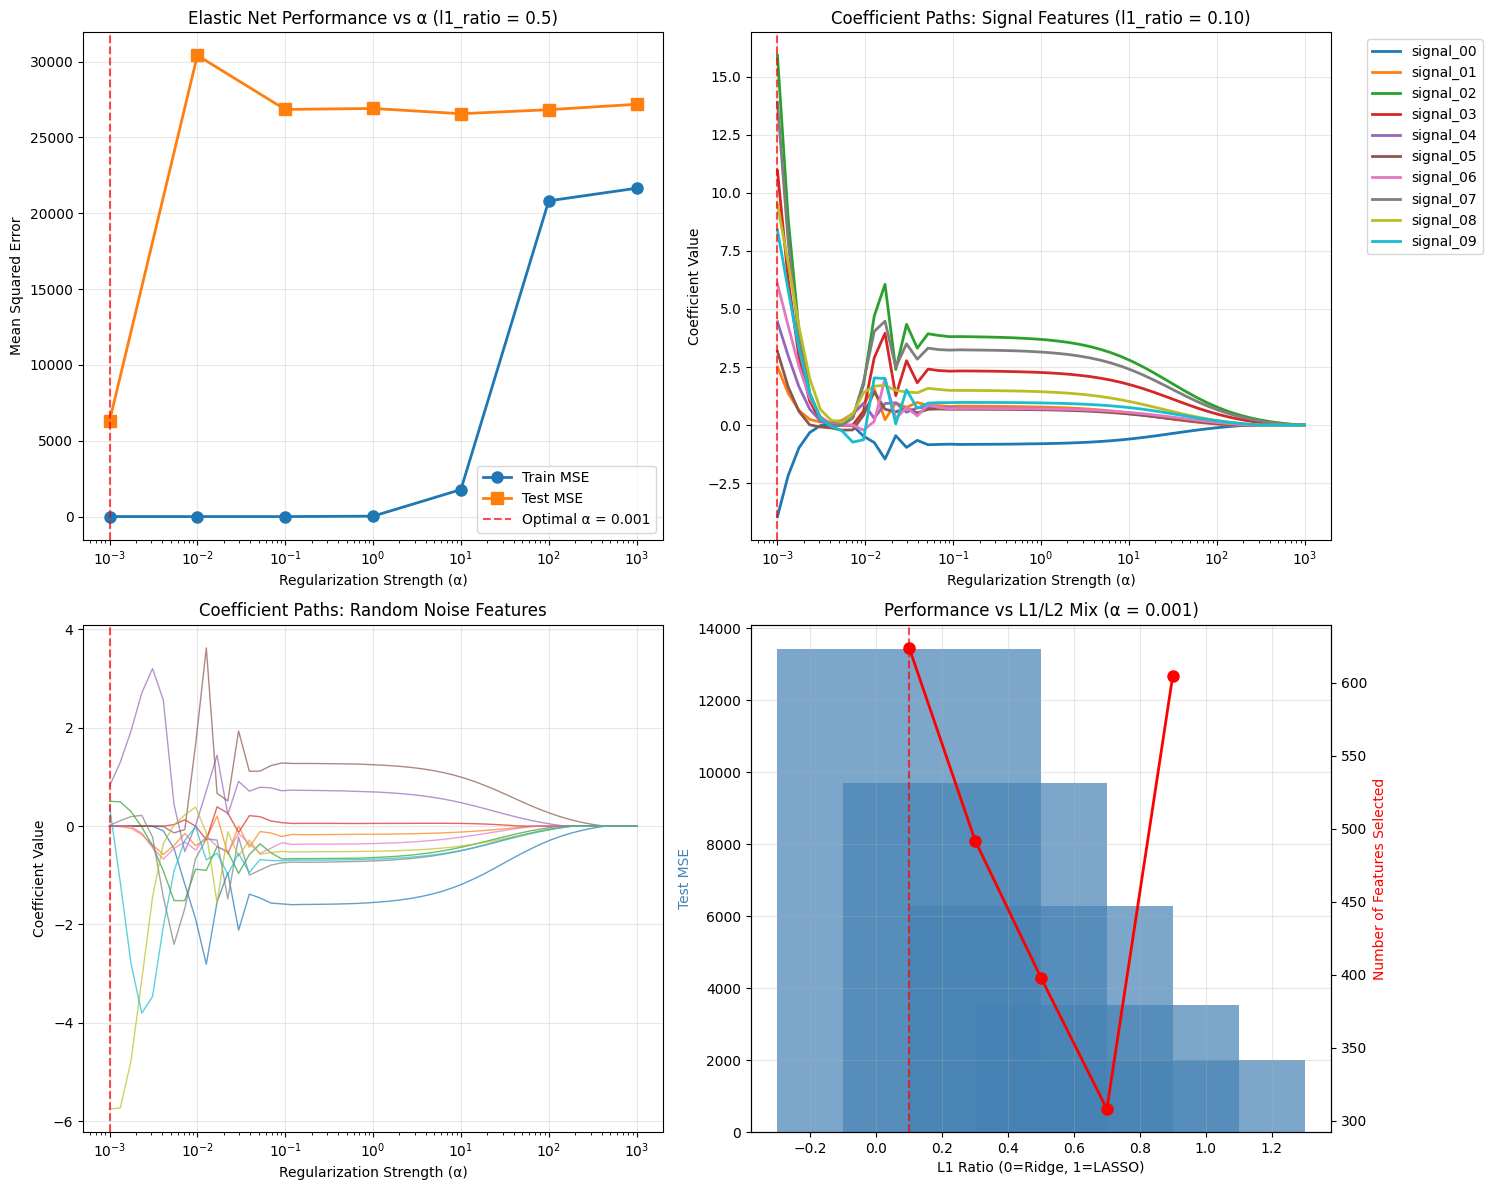


🔍 FEATURE SELECTION ANALYSIS:
  Optimal α = 0.001, l1_ratio = 0.100
Total features selected: 624
Signal features selected: 10 / 10
Noise features selected: 614 / 990
Signal features found: ['signal_00', 'signal_01', 'signal_02', 'signal_03', 'signal_04', 'signal_05', 'signal_06', 'signal_07', 'signal_08', 'signal_09']
First 10 noise features selected: ['noise_000', 'noise_001', 'noise_002', 'noise_003', 'noise_004', 'noise_005', 'noise_006', 'noise_007', 'noise_008', 'noise_009']...


In [43]:
# Visualize Elastic Net performance across alpha values
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Performance vs Alpha (MSE)
ax1.semilogx(alphas, train_mse, 'o-', label='Train MSE', linewidth=2, markersize=8)
ax1.semilogx(alphas, test_mse, 's-', label='Test MSE', linewidth=2, markersize=8)
ax1.axvline(x=optimal_alpha, color='red', linestyle='--', alpha=0.7, label=f'Optimal α = {optimal_alpha:.3f}')
ax1.set_xlabel('Regularization Strength (α)')
ax1.set_ylabel('Mean Squared Error')
ax1.set_title(f'Elastic Net Performance vs α (l1_ratio = {l1_ratio})')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Coefficient paths for signal features
elastic_coefs = []
alpha_range = np.logspace(-3, 3, 50)
for alpha in alpha_range:
    elastic = ElasticNet(alpha=alpha, l1_ratio=optimal_l1_ratio, max_iter=2000)
    elastic.fit(X_train_scaled, y_train)
    elastic_coefs.append(elastic.coef_)

elastic_coefs = np.array(elastic_coefs)

# Plot coefficient paths for first 10 features (true signals)
for i in range(10):
    ax2.semilogx(alpha_range, elastic_coefs[:, i], linewidth=2, label=f'signal_{i:02d}')
ax2.axvline(x=optimal_alpha, color='red', linestyle='--', alpha=0.7)
ax2.set_xlabel('Regularization Strength (α)')
ax2.set_ylabel('Coefficient Value')
ax2.set_title(f'Coefficient Paths: Signal Features (l1_ratio = {optimal_l1_ratio:.2f})')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

# Plot 3: Sample of noise feature coefficients
noise_indices = np.random.choice(range(10, 1000), 10, replace=False)
for i in noise_indices:
    ax3.semilogx(alpha_range, elastic_coefs[:, i], linewidth=1, alpha=0.7)
ax3.axvline(x=optimal_alpha, color='red', linestyle='--', alpha=0.7)
ax3.set_xlabel('Regularization Strength (α)')
ax3.set_ylabel('Coefficient Value')
ax3.set_title('Coefficient Paths: Random Noise Features')
ax3.grid(True, alpha=0.3)

# Plot 4: Performance across different l1_ratios
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
l1_performance = []

for l1_r in l1_ratios:
    elastic_test = ElasticNet(alpha=optimal_alpha, l1_ratio=l1_r, max_iter=2000)
    elastic_test.fit(X_train_scaled, y_train)
    test_pred = elastic_test.predict(X_test_scaled)
    test_mse_l1 = mean_squared_error(y_test, test_pred)
    n_selected = np.sum(elastic_test.coef_ != 0)
    l1_performance.append({'l1_ratio': l1_r, 'test_mse': test_mse_l1, 'n_features': n_selected})

l1_perf_df = pd.DataFrame(l1_performance)

# Create twin axis for features selected
ax4_twin = ax4.twinx()
bars = ax4.bar(l1_perf_df['l1_ratio'], l1_perf_df['test_mse'], 
               alpha=0.7, color='steelblue', label='Test MSE')
line = ax4_twin.plot(l1_perf_df['l1_ratio'], l1_perf_df['n_features'], 
                     'ro-', linewidth=2, markersize=8, label='Features Selected')

ax4.axvline(x=optimal_l1_ratio, color='red', linestyle='--', alpha=0.7)
ax4.set_xlabel('L1 Ratio (0=Ridge, 1=LASSO)')
ax4.set_ylabel('Test MSE', color='steelblue')
ax4_twin.set_ylabel('Number of Features Selected', color='red')
ax4.set_title(f'Performance vs L1/L2 Mix (α = {optimal_alpha:.3f})')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze which features were selected at optimal parameters
elastic_optimal = ElasticNet(alpha=optimal_alpha, l1_ratio=optimal_l1_ratio, max_iter=2000)
elastic_optimal.fit(X_train_scaled, y_train)

selected_features = X.columns[elastic_optimal.coef_ != 0]
signal_features_selected = [f for f in selected_features if f.startswith('signal_')]
noise_features_selected = [f for f in selected_features if f.startswith('noise_')]

print(f"\n🔍 FEATURE SELECTION ANALYSIS:")
print(f"  Optimal α = {optimal_alpha:.3f}, l1_ratio = {optimal_l1_ratio:.3f}")
print("=" * 60)
print(f"Total features selected: {len(selected_features)}")
print(f"Signal features selected: {len(signal_features_selected)} / 10")
print(f"Noise features selected: {len(noise_features_selected)} / 990")
print(f"Signal features found: {signal_features_selected}")
if len(noise_features_selected) <= 10:
    print(f"Noise features selected: {noise_features_selected}")
else:
    print(f"First 10 noise features selected: {noise_features_selected[:10]}...")

Understanding the L1 Ratio Plot (lower right):
X-axis: L1 Ratio (0=Ridge, 1=LASSO)

0.0: Pure Ridge regression (100% L2 penalty)
0.5: Equal mix of Ridge and LASSO (50% L1 + 50% L2)
1.0: Pure LASSO regression (100% L1 penalty)
Left Y-axis (Blue bars): Test MSE

Shows prediction error for each mixing ratio
Lower bars = better performance
Right Y-axis (Red line): Number of Features Selected

Shows how many features have non-zero coefficients
Decreases as we move toward LASSO (more feature selection)

-> but .9 ha many features again? and the loss is the lowest the more we go to lasso, which makes sense in this case probably because we actualy want to eliminate as many features as possible as many are noise no?

## Regularization Methods Overview

### Method Comparison

| Method | Penalty | Feature Selection | Correlated Features | Interpretability |
|--------|---------|-------------------|-------------------|------------------|
| **Ridge** | L2 (Σβ²) | No - shrinks only | Handles well | Limited |
| **LASSO** | L1 (Σ\|β\|) | Yes - automatic | Arbitrary selection | High |
| **Elastic Net** | L1 + L2 | Yes - controlled | Group selection | Good |

### Ridge Regression
**Use when:** You have many correlated predictors and want to reduce overfitting without removing variables

**Advantages:**
- Excellent for multicollinearity - distributes weight across correlated features
- Computationally efficient with closed-form solutions
- Stable and robust to small data changes

**Disadvantages:**
- No automatic feature selection - keeps all variables with small coefficients
- Limited interpretability - difficult to identify truly important features

### LASSO Regression  
**Use when:** You want sparse, interpretable models with automatic variable selection

**Advantages:**
- Automatic feature selection - eliminates irrelevant variables completely
- High interpretability - clear distinction between selected/ignored features
- Works excellently when few features truly matter

**Disadvantages:**
- May select only one variable from a group of highly correlated predictors
- Can underperform when predictors are highly collinear
- Sensitive to data changes - may lead to different feature selections

### Elastic Net
**Use when:** You need both variable selection and ability to handle grouped selection of correlated variables

**Advantages:**
- Combines Ridge stability with LASSO sparsity
- Handles correlated feature groups better than LASSO alone
- Often outperforms Ridge or LASSO alone in high-dimensional datasets
- More robust feature selection than pure LASSO

**Disadvantages:**
- Two hyperparameters to tune (α and l1_ratio) - more complex optimization
- Higher computational cost - requires grid search over both parameters